In [27]:
import re
import pandas as pd
import numpy as np
#%% 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import *
import datetime as dt
from matplotlib.ticker import MaxNLocator
import regex
import emoji
# from seaborn import *
# from seaborn import heatmap
from wordcloud import WordCloud , STOPWORDS , ImageColorGenerator
from nltk import *
from plotly import express as px



In [28]:
def startsWithDateAndTime(s):
    pattern = '^([0-9]+)(/)([0-9]+)(/)([0-9]+), ([0-9]+):([0-9]+)( am| pm) -'
    result = re.match(pattern, s)
    if result:
        return True
    return False



# #24-hr format 
# def startsWithDateAndTime(s):
#     pattern = '^([0-9]+)/([0-9]+)/([0-9]+), ([0-9]+):([0-9]+) -'
#     result = re.match(pattern, s)
#     if result:
#         return True
#     return False

In [29]:

def FindAuthor(s):
    patterns = [
        '([a-zA-Z]+):',                        # First Name
        '([a-zA-Z]+\s[a-zA-Z]+):',              # First Name + Last Name
        '([a-zA-Z]+\s[a-zA-Z]+\s[a-zA-Z]+):',    # First Name + Middle Name + Last Name
        '([+][0-9]{2}\s[0-9]{5}\s[0-9]{5}):',         # Mobile Number (India no.)
        '([+][0-9]{2}\s[0-9]{3}\s[0-9]{3}\s[0-9]{4}):',   # Mobile Number (US no.)
        '([a-zA-Z]+[\u263a-\U0001f999]+:)',    # Name and Emoji              
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False



In [30]:
def getDataPoint(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(': ') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

In [31]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
### Uploading exported chat file
conversationPath = '/WhatsApp Chat with Psyan.txt' # chat file
with open(conversationPath, encoding="utf-8") as fp:
    ### Skipping first line of the file because contains information related to something about end-to-end encryption
    fp.readline() 
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        line = line.strip() 
        if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
        else:
            messageBuffer.append(line)
          
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
### changing datatype of "Date" column.
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)


In [32]:
### Checking shape of dataset.
df.shape
### Checking basic information of dataset
df.info()
### Checking no. of null values in dataset
df.isnull().sum()
### Checking head part of dataset
df.head(50)
### Checking tail part of dataset
df.tail(50)
### Droping Nan values from dataset
df = df.dropna()
df = df.reset_index(drop=True)
df.shape
### Checking no. of authors of group
df['Author'].nunique()
### Checking authors of group
df['Author'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4584 entries, 0 to 4583
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     4584 non-null   datetime64[ns]
 1   Time     4584 non-null   object        
 2   Author   4584 non-null   object        
 3   Message  4584 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 143.4+ KB


array(['Psyan', 'Diablo'], dtype=object)

In [33]:
### Adding one more column of "Day" for better analysis, here we use datetime library which help us to do this task easily.
weeks = {
0 : 'Monday',
1 : 'Tuesday',
2 : 'Wednesday',
3 : 'Thrusday',
4 : 'Friday',
5 : 'Saturday',
6 : 'Sunday'
}
df['Day'] = df['Date'].dt.weekday.map(weeks)
### Rearranging the columns for better understanding
df = df[['Date','Day','Time','Author','Message']]
### Changing the datatype of column "Day".
df['Day'] = df['Day'].astype('category')
### Looking newborn dataset.
df.head()
### Counting number of letters in each message
df['Letters'] = df['Message'].apply(lambda s : len(s))
### Counting number of word's in each message
df['Words'] = df['Message'].apply(lambda s : len(s.split(' ')))
### Function to count number of links in dataset, it will add extra column and store information in it.

URLPATTERN = r'(https?://S+)'
df['Url_Count'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = np.sum(df.Url_Count)
### Function to count number of media in chat.
MEDIAPATTERN = r'<Media omitted>'
df['Media_Count'] = df.Message.apply(lambda x : re.findall(MEDIAPATTERN, x)).str.len()
media = np.sum(df.Media_Count)
### Looking updated dataset
df

,Date,Day,Time,Author,Message,Letters,Words,Url_Count,Media_Count
0,2021-09-18,Saturday,8:23 pm,Psyan,hey o/,6,2,0,0
1,2021-09-18,Saturday,9:10 pm,Diablo,Hello . Who is this ?,21,6,0,0
2,2021-09-18,Saturday,10:46 pm,Psyan,* has an identity crisis * who am i,35,9,0,0
3,2021-09-18,Saturday,10:48 pm,Psyan,O_o,3,1,0,0
4,2021-09-18,Saturday,10:48 pm,Diablo,Huh ?,5,2,0,0
...,...,...,...,...,...,...,...,...,...
4579,2023-01-18,Wednesday,12:00 am,Diablo,BEEN waiting since 1 Hr,23,5,0,0
4580,2023-01-18,Wednesday,12:01 am,Diablo,AAAAAAA you're sleeping 😴 sleepyhead,37,6,0,0
4581,2023-01-18,Wednesday,12:01 am,Diablo,"Anyway, I've made something for you",35,6,0,0
4582,2023-01-18,Wednesday,12:13 am,Diablo,https://www.greetingsisland.com/ecard/pycwvcbo...,50,1,0,0


In [34]:
total_messages = df.shape[0]
media_messages = df[df['Message'] == '<Media omitted>'].shape[0]
links = np.sum(df.Url_Count)
print('Group Chatting Stats : ')
print('Total Number of Messages : {}'.format(total_messages))
print('Total Number of Media Messages : {}'.format(media_messages))
print('Total Number of Links : {}'.format(links))

Group Chatting Stats : 
Total Number of Messages : 4584
Total Number of Media Messages : 487
Total Number of Links : 0


In [35]:
print(df.columns)


Index(['Date', 'Day', 'Time', 'Author', 'Message', 'Letters', 'Words',
       'Url_Count', 'Media_Count'],
      dtype='object')


In [36]:
l = df.Author.unique()
for i in range(len(l)):
  ### Filtering out messages of particular user
  req_df = df[df["Author"] == l[i]]
  ### Renaming the column name to avoid SyntaxError
  req_df = req_df.rename(columns={'Word\'s': 'Words'})

  
  ### req_df will contain messages of only one particular user
  print(f'--> Stats of {l[i]} <-- ')
  ### shape will print number of rows which indirectly means the number of messages
  print('Total Message Sent : ', req_df.shape[0])
  ### Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Words']))/req_df.shape[0]
  w_p_m = ("%.3f" % round(words_per_message, 2))  
  print('Average Words per Message : ', w_p_m)
  ### media conists of media messages
  media = sum(req_df["Media_Count"])
  print('Total Media Message Sent : ', media)
  ### links consist of total links
  links = sum(req_df["Url_Count"])   
  print('Total Links Sent : ', links)   
  print()
  print('----------------------------------------------------------n')


--> Stats of Psyan <-- 
Total Message Sent :  2101
Average Words per Message :  5.290
Total Media Message Sent :  248
Total Links Sent :  0

----------------------------------------------------------n
--> Stats of Diablo <-- 
Total Message Sent :  2483
Average Words per Message :  4.970
Total Media Message Sent :  239
Total Links Sent :  0

----------------------------------------------------------n


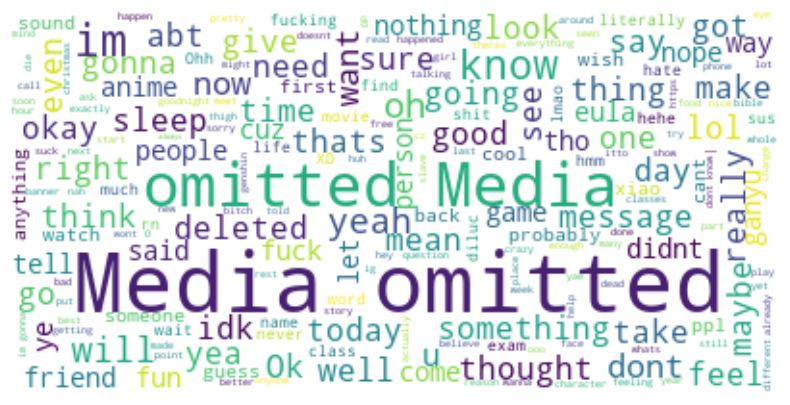

In [37]:
### Word Cloud of mostly used word in our Group
text = " ".join(review for review in df.Message)
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(text)
  ### Display the generated image:
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [38]:
### Creates a list of unique Authors
l = df.Author.unique()
for i in range(len(l)):
  ### Filtering out messages of particular user
  req_df = df[df["Author"] == l[i]]
  ### req_df will contain messages of only one particular user
  print(l[i],'  ->  ',req_df.shape[0])

Psyan   ->   2101
Diablo   ->   2483


In [25]:
l = df.Day.unique()
for i in range(len(l)):
  ### Filtering out messages of particular user
  req_df = df[df["Day"] == l[i]]
  ### req_df will contain messages of only one particular user
  print(l[i],'  ->  ',req_df.shape[0])

Saturday   ->   668
Sunday   ->   675
Wednesday   ->   632
Thrusday   ->   910
Monday   ->   380
Tuesday   ->   657
Friday   ->   662


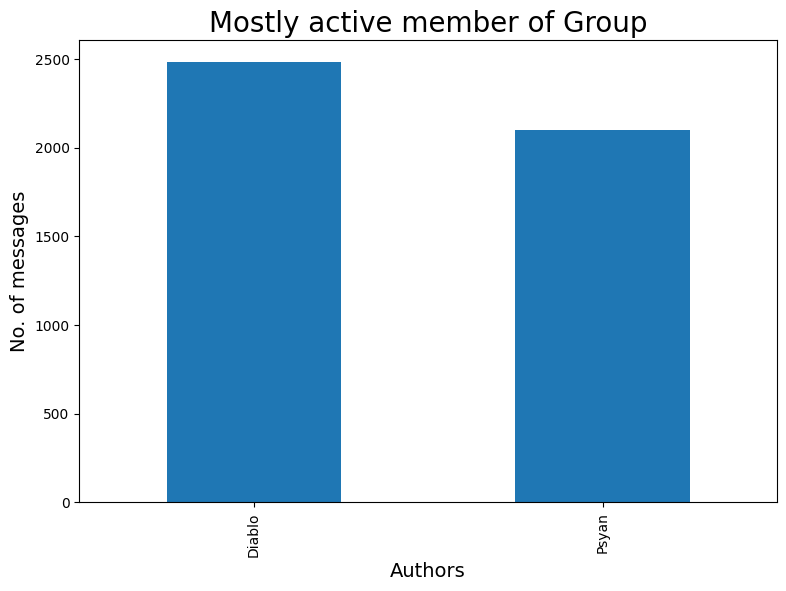

In [26]:
#%%

### Mostly Active Author in the Group
plt.figure(figsize=(9,6))
mostly_active = df['Author'].value_counts()
### Top 10 peoples that are mostly active in our Group is : 
m_a = mostly_active.head(10)
bars = m_a.index
x_pos = np.arange(len(bars))
m_a.plot.bar()
plt.xlabel('Authors',fontdict={'fontsize': 14,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 14,'fontweight': 10})
plt.title('Mostly active member of Group',fontdict={'fontsize': 20,'fontweight': 8})
plt.xticks(x_pos, bars)
 
plt.show()

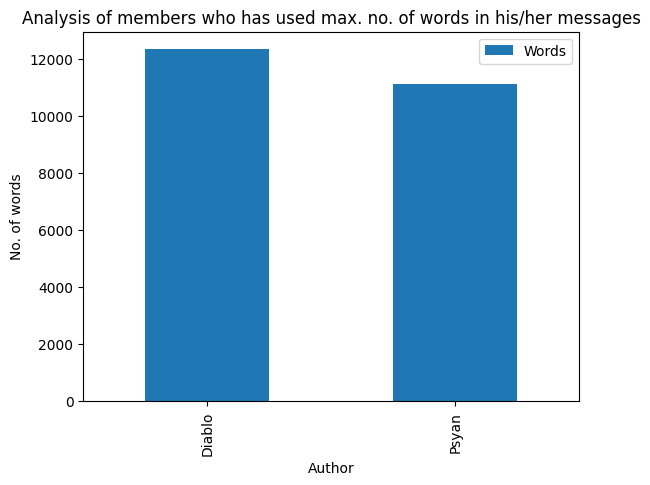

In [27]:
max_words = df[['Author','Words']].groupby('Author').sum()
m_w = max_words.sort_values('Words',ascending=False).head(10)
bars = m_a.index
x_pos = np.arange(len(bars))
m_w.plot.bar(rot=90)
plt.xlabel('Author')
plt.ylabel('No. of words')
plt.title('Analysis of members who has used max. no. of words in his/her messages')
plt.xticks(x_pos, bars)
plt.show()

In [28]:
# Group the dataframe by 'Author'
grouped_df = df.groupby(['Author'])

# Use the sum() method to get the total number of words sent by each user
total_words = grouped_df['Words'].sum()

# Print the result
print(total_words)
for author, words in total_words.items():
    print(f'{author} sent {words} words')


Author
Diablo    12343
Psyan     11115
Name: Words, dtype: int64
Diablo sent 12343 words
Psyan sent 11115 words


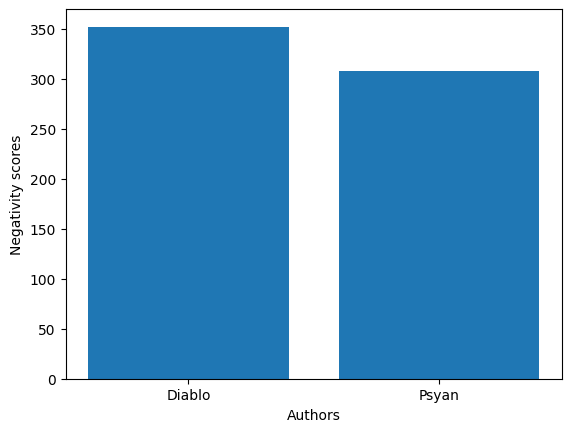

In [29]:
from nltk.sentiment import SentimentIntensityAnalyzer



sia = SentimentIntensityAnalyzer()

df['sentiment'] = df['Message'].apply(lambda x: sia.polarity_scores(x)['compound'])
df_authors = df.groupby("Author")["Message"].apply(lambda x: x.tolist()).to_dict()
for author in df_authors:
    messages = df_authors[author]
    compound_sentiment = [sia.polarity_scores(x)["compound"] for x in messages]
    df_authors[author] = compound_sentiment
    negativity_scores = {}
for author in df_authors:
    negativity_scores[author] = sum([x<0 for x in df_authors[author]])

plt.bar(negativity_scores.keys(), negativity_scores.values())
plt.xlabel('Authors')
plt.ylabel('Negativity scores')
plt.show()

In [30]:
negative_sentences = df[df['sentiment'] < 0]['Message'].tolist()
positive_sentences = df[df['sentiment'] > 0]['Message'].tolist()

print("Negative sentences:")
for sentence in negative_sentences:
    print(sentence)
    
print("Positive sentences:")
for sentence in positive_sentences:
    print(sentence)


Negative sentences:
* has an identity crisis * who am i
O_o
What no
didnt you say it was getting slighly boring 👀
it means i have the power to call you rn and ruin your sleep rgt
5 am WTF
I will disturb you at ungodly hours
I hate collectiong oculii
Use your fragile resins... I want to see you broke and begging for resins as well
Yeee ... now you can also get fucked by azdaha
Did you find Miss Ei intriguing?
That's why inazuma has crap story
is it actually that terrible or did the fandom convince you its terrible
No I am a pussy
why are you on discord only AFTER i close my laptop😫
:/
Idk qhat elese to do
ooo mid life crisis
sticker war?
Nono .... she had such a manly voice,  I got confused
I'll murder you first
No it's not 😃
idk why it says. i sleep at least 6hrs sooo that shouldnt be possible
dont care XD
nah
but no shoes left behind
why would you leave behind shoes tho
no resins left behind?👀
i dont like cinderella
i dont think anybody does. shes almost as annoying as snow white
idk 

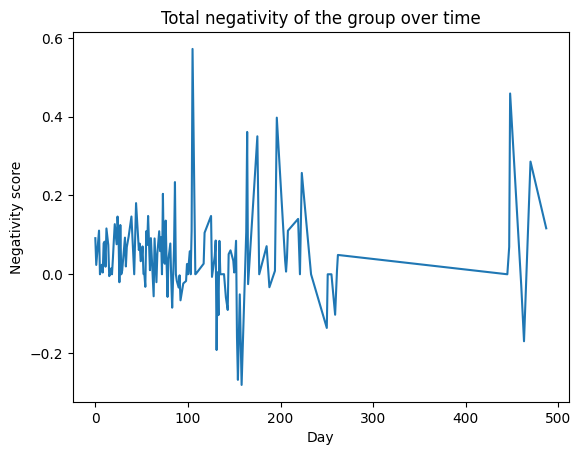

In [31]:
# add a new column that represents the number of days since the first message
df["Day"] = (df["Date"] - df["Date"].min()).dt.days

# group the dataframe by the new column and calculate the mean negativity score for each day
df_grouped = df.groupby("Day").mean()

#The module calculates a sentiment score between -1 and 1, where -1 represents a negative sentiment, 0 represents a neutral sentiment, 
# and 1 represents a positive sentiment. A negative score implies a negative sentiment in the text.
# create a line chart
plt.plot(df_grouped.index, df_grouped["sentiment"])
plt.xlabel('Day')
plt.ylabel('Negativity score')
plt.title('Total negativity of the group over time')
plt.show()


In [ ]:
#DO NOT EXECUTE
import http.client, urllib.request, urllib.parse, urllib.error, base64, json   

def get_toxicity_score(text):
    text = text.encode('utf-8')
    headers = {
        'Content-Type': 'text/plain',
        'Ocp-Apim-Subscription-Key': '70fd210ab7c24175a34188db6153b416',
    }
    params = urllib.parse.urlencode({
        'autocorrect': 'True',
        'PII': 'False',
        'classify': 'True',
        'language': 'eng',
    })
    try:
        conn = http.client.HTTPSConnection('eastasia.api.cognitive.microsoft.com')
        conn.request("POST", "/contentmoderator/moderate/v1.0/ProcessText/Screen?%s" % params, text, headers)
        response = conn.getresponse()
        data = response.read()
        
        print(data)
        conn.close()
    except Exception as e:
     print("[Errno {0}] {1}".format(e.errno, e.strerror))
    
df_authors = df.groupby("Author")["Message"].apply(lambda x: x.tolist()).to_dict()

toxicity_scores = {}
for author in df_authors:
 messages = df_authors[author][:500] # only checking the first 1000 messages
for msg in messages:
 toxicity_score = get_toxicity_score(msg)
 if toxicity_score is not None:
    if author not in toxicity_scores:
        toxicity_scores[author] = []
    toxicity_scores[author].append(toxicity_score)



print(toxicity_scores)
for author in toxicity_scores:
    non_none_values = [val for val in toxicity_scores[author] if val is not None]
    avg_toxicity = sum(non_none_values) / len(non_none_values)
    plt.bar(author, avg_toxicity)

plt.xlabel("Author")
plt.ylabel("Toxicity Score")
plt.show()

{'Diablo': [False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False], 'Psyan': [False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False]}


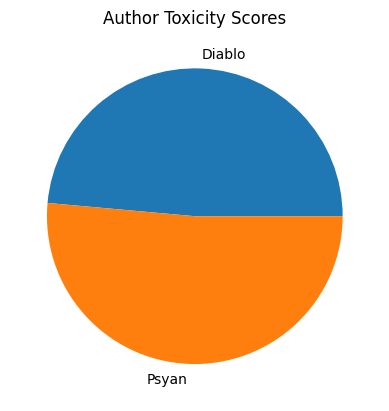

In [63]:
import http.client, urllib.request, urllib.parse, urllib.error, base64, json   # GC-toxicity

def get_toxicity_score(text):
    text = text.encode('utf-8')
    headers = {
        'Content-Type': 'text/plain',
        'Ocp-Apim-Subscription-Key': 'abc7a176fc97427fbf80863cd9c51eab',
    }
    params = urllib.parse.urlencode({
        'autocorrect': 'True',
        'PII': 'False',
        'classify': 'True',
        'language': 'eng',
    })
    try:
        conn = http.client.HTTPSConnection('eastasia.api.cognitive.microsoft.com')
        conn.request("POST", "/contentmoderator/moderate/v1.0/ProcessText/Screen?%s" % params, text, headers)
        response = conn.getresponse()
        if response is not None and response.status == 200:
            data = json.loads(response.read())
            if data is not None and 'Classification' in data and 'ReviewRecommended' in data['Classification']:
                toxicity_score = data["Classification"]["ReviewRecommended"]
                conn.close()
                return toxicity_score
    except Exception as e:
        print("Error getting toxicity score:", e)
        return None
    
df_authors = df.groupby("Author")["Message"].apply(lambda x: x.tolist()).to_dict()

toxicity_scores = {}
for author in df_authors:
    messages = df_authors[author][:50] # only checking the first 1000 messages. For full messages use messages = df_authors[author]
    for msg in messages:
        toxicity_score = get_toxicity_score(msg)
        if toxicity_score is not None:
            if author not in toxicity_scores:
                toxicity_scores[author] = [toxicity_score]
            else:
                toxicity_scores[author].append(toxicity_score)




print(toxicity_scores)
authors = []
avg_toxicity_scores = []
for author in toxicity_scores:
    non_none_values = [val for val in toxicity_scores[author] if val is not None]
    avg_toxicity = sum(non_none_values) / len(non_none_values)
    authors.append(author)
    avg_toxicity_scores.append(avg_toxicity)

# Create the pie chart
plt.pie(avg_toxicity_scores, labels=authors)
plt.title("Author Toxicity Scores")
plt.show()


In [39]:
import numpy as np
import pandas as pd
import re
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

df['Sentiment'] = df['Message'].apply(get_sentiment)

X_train, X_test, y_train, y_test = train_test_split(df['Message'], df['Sentiment'], test_size=0.2, random_state=1)

cv = CountVectorizer()
X_train_counts = cv.fit_transform(X_train)

nb = MultinomialNB()
nb.fit(X_train_counts, y_train)

X_test_counts = cv.transform(X_test)
y_pred = nb.predict(X_test_counts)

accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)


Accuracy: 0.8647764449291166


In [40]:
prediction = nb.predict(X_test_counts) # predict the sentiment of test set

# create two lists to store positive and negative sentences
positive_sentences = []
negative_sentences = []

# loop through the test set and add sentences to corresponding list
for i in range(len(X_test)):
    if prediction[i] == 'positive':
        positive_sentences.append(X_test.iloc[i])
    elif prediction[i] == 'negative':
        negative_sentences.append(X_test.iloc[i])

# display positive sentences
print("Positive Sentences:")
for sentence in positive_sentences:
    print(sentence)

# display negative sentences
print("\nNegative Sentences:")
for sentence in negative_sentences:
    print(sentence)



Positive Sentences:
they are all cool
I am a very patient person
Kokomi is clear .. she is way too good
the name is familiar
yeah right polite. i dont think i would be me if i was "polite"
wow okay i take it bakc 🙄
Sure sure
i wasnt shit talking him i was shit talking his gambling additction
gay
Like really cold that my hands are freezing
Dw we'll buy a better one
its me practicing self control with character banner. thats it
maybe this si what it feels to get fucked both ways
i watched it there other day, the art and aesthetics are really nice, the story is good too although the ending was slightly cringe but hey cant complain
where is it? wheres the bible girl?
Cool is cool
yeah thats true😔
i wish i stared at this more
i need more stickers
thats the whole point
Your interest in the morning and the other side of the family is a bit more complicated than we thought because I don't want to have anything to do with the fact that you don't want me to take over.
I would have said itto , bu